# Anisotropic AVO equations

I will show two equations to compute the reflectivity variations with angle of incidence for anisotropic media and also write down some remarks on practical selection of default values for real applications.

For more information see also:

* [Agilegeo's post on anisotropy](https://www.agilescientific.com/blog/2015/2/9/what-is-anisotropy)
* [Agilegeo's post on Blangy's equation](https://www.agilescientific.com/blog/2014/8/7/the-blangy-equation.html)

Anisotropy is defined by the two Thomsen's parameters, $\epsilon$ and $\delta$ which are explained in layman's terms as:

*  $\varepsilon$: P-wave anisotropy, i.e. the fractional difference between vertical and horizontal velocity, and usually  $\epsilon > 0$ (which means that acoustic waves travel faster horizontally than vertically). It is known as the _long offset term_ as it only becomes relevant at large offsets.
* $\delta$: is perhaps the most important anisotropy parameter, indipendent of horizontal velocity and dominates at short offsets (therefore it is also called the _short offset term_). It can be either positive or negative.
* $\gamma$: S-wave anisotropy

$$ \varepsilon = \frac{V_p(90) - V_p(0)}{V_p(0)} $$

$$ \delta = \frac{(C_{13}+C_{44})^2 -(C_{33}-C_{44})^2}{2C_{33}(C_{33}-C_{44})} $$

$$ \gamma = \frac{V_sh(90) - V_sh(0)}{V_sh(0)} $$

I will use the equation introduced by Blangy (1994) and Ruger (1997). The first one was coded by the nice folks over at AgileGeo and copied directly from their [bruges](https://www.agilegeoscience.com/bruges/) library. The second one I'm afraid I've coded it myself, and you'll never know the two hours of despair when my results weren't matching what was shown in the article; could I possibly be so stupid and not being able to simply transcribe a (simple) equation? Read on and see it for yourself.



### (additional) references

In addition to the two posts on Agile Scientific's blog, these are the original papers that needs to be acknowledged, plus the third is the usual hands-on, very practical book that I always recommend:

* Blangy, J. P., 1994, AVO in transversely isotropic media An overview: Geophysics, v. 59, no. 5, p. 775–781.
* Rüger, A., 1997, P -wave reflection coefficients for transversely isotropic models with vertical and horizontal axis of symmetry: Geophysics, v. 62, no. 3, p. 713–722.
* Simm & Bacon, Seismic Amplitude: An Interpreter's Handbook, Cambridge University Press, 2014.


## Various functions

`blangy` and `ruger` to compute angle-dependent reflectivity curves taking into account anisotropy parameters $\epsilon$ and $\delta$. `rpc` is used to interrogate the online [Rock Property Catalog](https://agilescientific.com/blog/2015/10/5/the-rock-property-catalog-again).

In [2]:
def blangy(vp1,vs1,rho1,d1,e1,vp2,vs2,rho2,d2,e2,theta):
    inc_angle = np.radians(theta)
    trans_angle = np.arcsin(np.sin(inc_angle) * vp2/vp1)
    theta = 0.5 * (inc_angle + trans_angle)
    vp  = (vp1 + vp2)/2.0
    vs  = (vs1 + vs2)/2.0
    rho  = (rho1 + rho2)/2.0
    dvp = vp2-vp1
    dvs = vs2-vs1
    drho = rho2-rho1
    dd = d2-d1
    de = e2-e1
    A = 0.5 * (drho/rho + dvp/vp)
    B = 2.0 * (vs**2 / vp**2) * ((drho/rho + 2 * dvs/vs)) * np.sin(theta)**2
    C = 0.5 * (dvp/vp) * np.tan(theta)**2
    D = 0.5 * dd * np.sin(theta)**2
    E = 0.5 * (dd - de) * np.sin(theta)**2 * np.tan(theta)**2
    isotropic = A - B + C
    anisotropic = A - B + C + D - E
    return isotropic, anisotropic, (A, -B, C, D, -E)

def ruger(vp1,vs1,rho1,d1,e1,vp2,vs2,rho2,d2,e2,theta):
    a = np.radians(theta)
    vp  = np.mean([vp1,vp2])
    vs  = np.mean([vs1,vs2])
    rho = np.mean([rho1,rho2])
    z   = np.mean([vp1*rho1,vp2*rho2])
    g   = np.mean([rho1*vs1**2,rho2*vs2**2])
    dvp = vp2-vp1
    dvs = vs2-vs1
    drho= rho2-rho1
    z2, z1 = vp2*rho2, vp1*rho1
    dz  = z2-z1
    dg  = rho2*vs2**2 - rho1*vs1**2
    dd = d2-d1
    de = e2-e1
    A = 0.5*(dz/z)
    B = 0.5*(dvp/vp - (2*vs/vp)**2 * (dg/g) + dd) * np.sin(a)**2
    C = 0.5*(dvp/vp + de) * np.sin(a)**2 * np.tan(a)**2
    R = A+B+C
    return R

In [3]:
#....................................................................
# from https://github.com/agile-geoscience/notebooks/blob/master/Query_the_RPC.ipynb
#.....................................................................
import requests
class RPC(object):
    def __init__(self):
        pass

    def _query_ssw(self, filters, properties, options):

        base_url = "http://www.subsurfwiki.org/api.php"
        q = "action=ask&query=[[RPC:%2B]]"
        q += ''.join(filters) if filters else ''
        q += '|%3F' + '|%3F'.join(properties) if properties else ''
        q += '|' + '|'.join(options) if options else ''
        q += '&format=json'

        return requests.get(base_url, params=q)

    def _get_formats(self, response):
        formats = {}
        for item in response.json()['query']['printrequests']:
            if item[u'mode'] == 1:
                formats[item[u'label']] = item[u'typeid'].lstrip('_')
        return formats

    def _build_dataframe(self, response):
        """
        Takes the response of a query and returns a pandas
        dataframe containing the results.
        """
        try:
            s = list(response.json()['query']['results'].keys())
        except Exception as e:
            raise e
        samples = [i[4:] for i in s]
        df = pd.DataFrame(samples)

        # We'll need to know the formats of the columns.
        formats = self._get_formats(response)
        properties = formats.keys()

        # Now traverse the JSON and build the DataFrame.
        for prop in properties:
            temp = []
            for row in list(s):
                p = response.json()['query']['results'][row]['printouts']
                if p[prop]:
                    if formats[prop] == 'qty':   # Quantity, number + unit
                        temp.append(p[prop][0]['value'])
                    elif formats[prop] == 'wpg':  # Wiki page
                        temp.append(p[prop][0]['fulltext'])
                    else:                         # Anything else: num, txt, tem, etc.
                        temp.append(p[prop][0])
                else:
                    temp.append(None)
            df[prop] = temp

        df = df.set_index(0)
        df.index.name = None

        return df

    def query(self, filters=None, properties=None, options=None):
        r = self._query_ssw(filters, properties, options)
        if r.status_code == 200:
            return self._build_dataframe(r)
        else:
            print("Something went wrong.")
#.....................................................................

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bruges.reflection import zoeppritz
import bruges as b
from IPython.display import Image

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

## what are the most common values for Thomsen's anisotropy parameters?

Let's what the [Rock Property Catalog](https://agilescientific.com/blog/2015/10/5/the-rock-property-catalog-again) tells us:

In [9]:
rpc = RPC()
filters = ["[[lithology::Shale]]"]
properties = ['Citation', 'Description', 'Lithology', 'Vp', 'Vs', 'Rho', 'Delta', 'Epsilon']
options = ["limit=5000"]
df = rpc.query(filters, properties,options)
# df.to_csv(dirdata+'RPC_anisotropy.dat')

((-0.25, 0.8), (-0.25, 0.8))

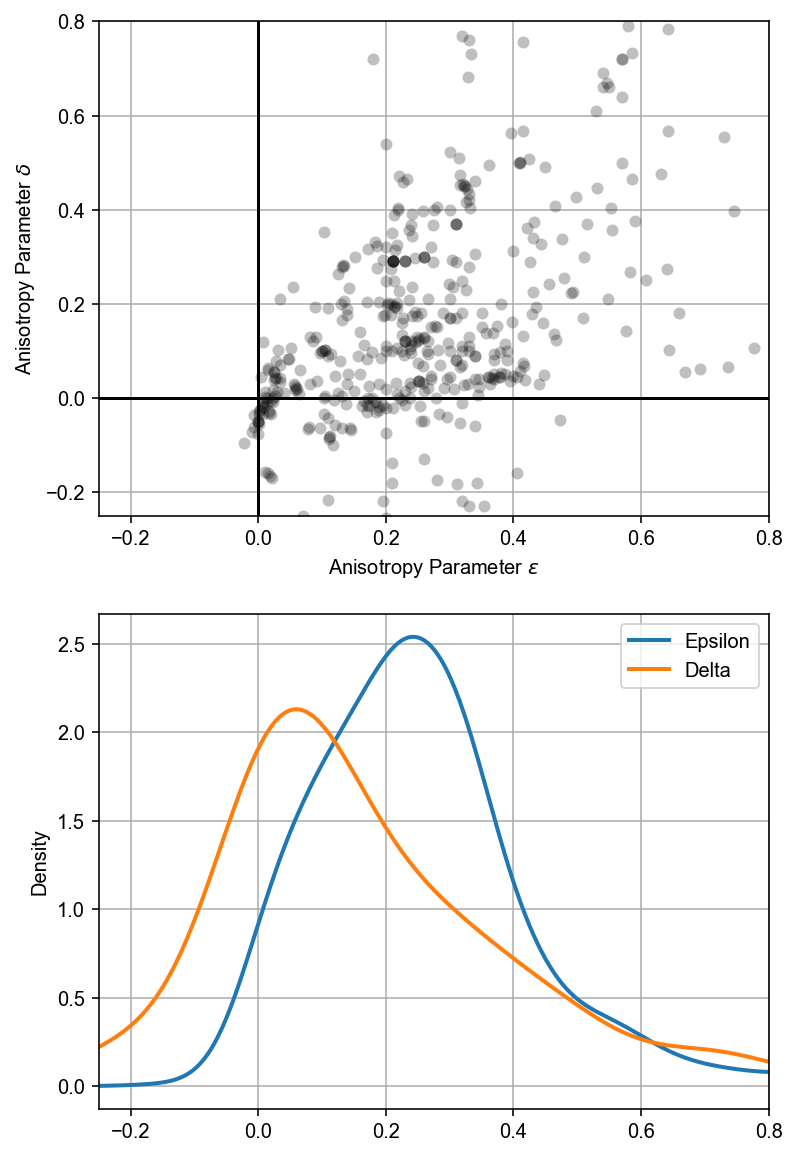

In [22]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,10))
ax[0].plot(df.Epsilon, df.Delta, marker='o',mec='none', ms=6, ls='none', mfc='k', alpha=0.25)

df.Epsilon.plot(kind='kde', ax=ax[1], legend=True, lw=2, xlim=(-0.25,0.8))
df.Delta.plot(kind='kde', ax=ax[1], legend=True, lw=2, xlim=(-0.25,0.8), grid=True,)
ax[0].set_xlabel(r'Anisotropy Parameter $\varepsilon$')
ax[0].set_ylabel('Anisotropy Parameter $\delta$')
ax[0].axhline(y=0,color='k')
ax[0].axvline(x=0,color='k')
ax[0].grid()
ax[0].set_xlim(-0.25,0.8), ax[0].set_ylim(-0.25,0.8)

Values used by Simm in his example (SA, p.86): $\varepsilon = 0.02$, $\delta = 0.15$

In Rüger's work instead we have $\delta = 0.12$ and $\varepsilon$ varying between $0.133$ and $0.233$ (see figures below). 

Rules of thumb (SA, p.84):

* generally $\delta > 0$ in shales, may not be zero in sands
* $\varepsilon > 0$ for sands and shales
* $\varepsilon$ is usually larger than $\delta$ by a factor of 2

## reproducing Ruger's figures from his PhD thesis

(it works!)

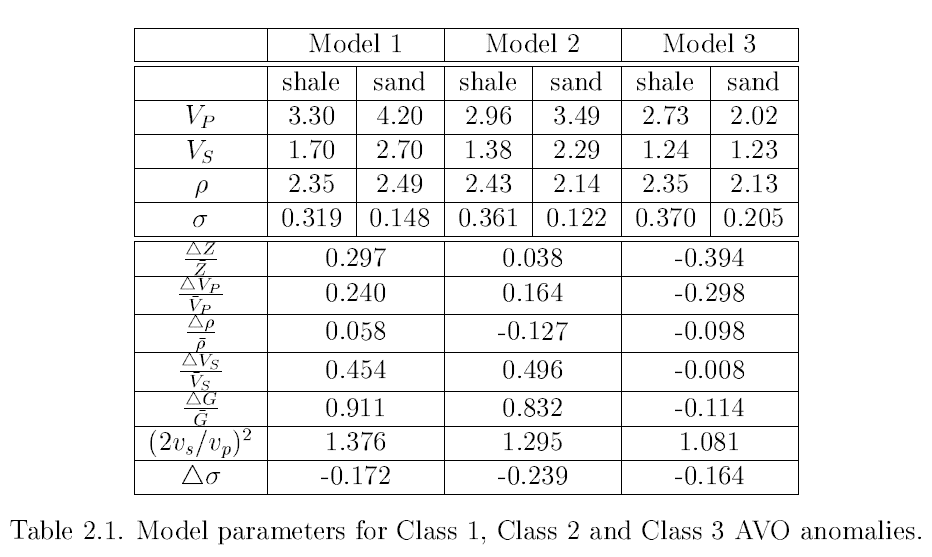

In [4]:
Image(filename='Ruger_1996_pag16_table2-1.png', width=1200, retina=True)

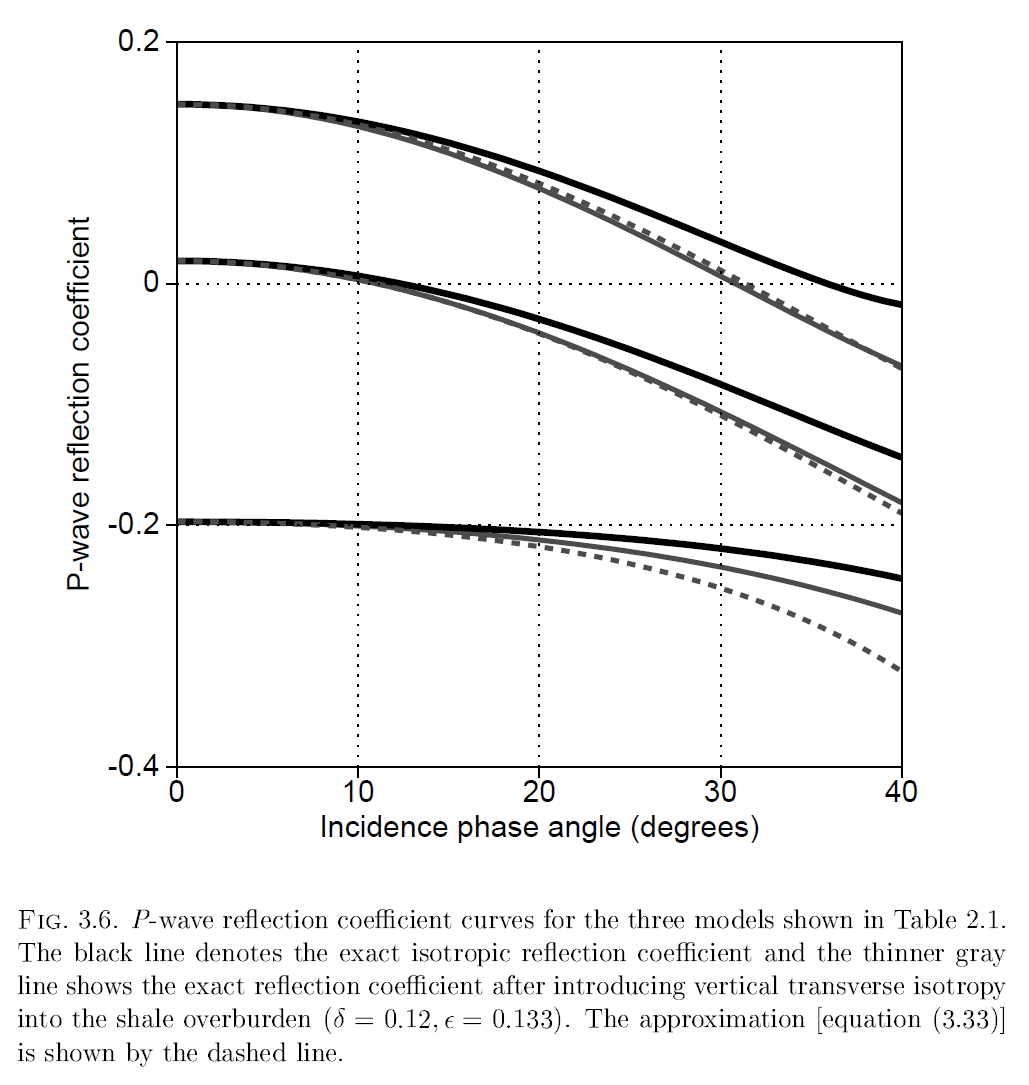

In [5]:
Image(filename='Ruger_1996_pag38_fig3-6.png', width=1200, retina=True)

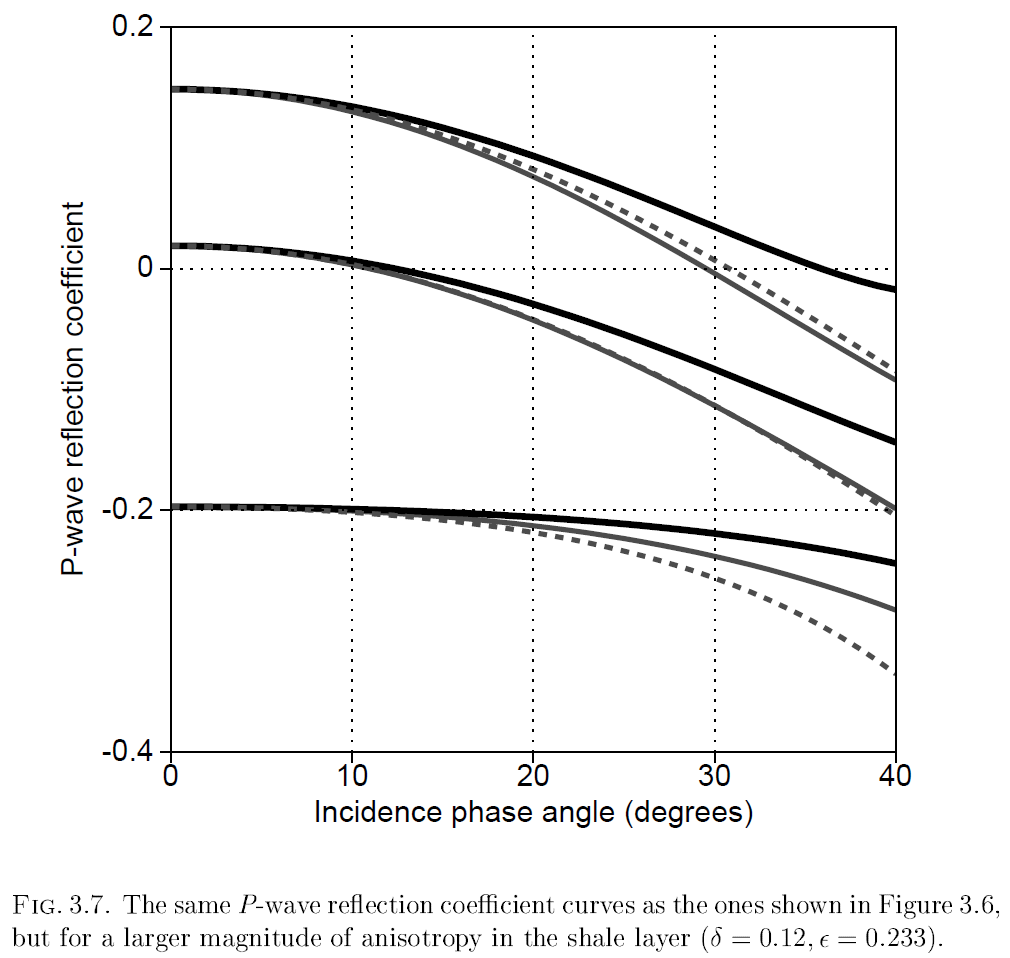

In [6]:
Image(filename='Ruger_1996_pag39_fig3-7.png', width=1200, retina=True)

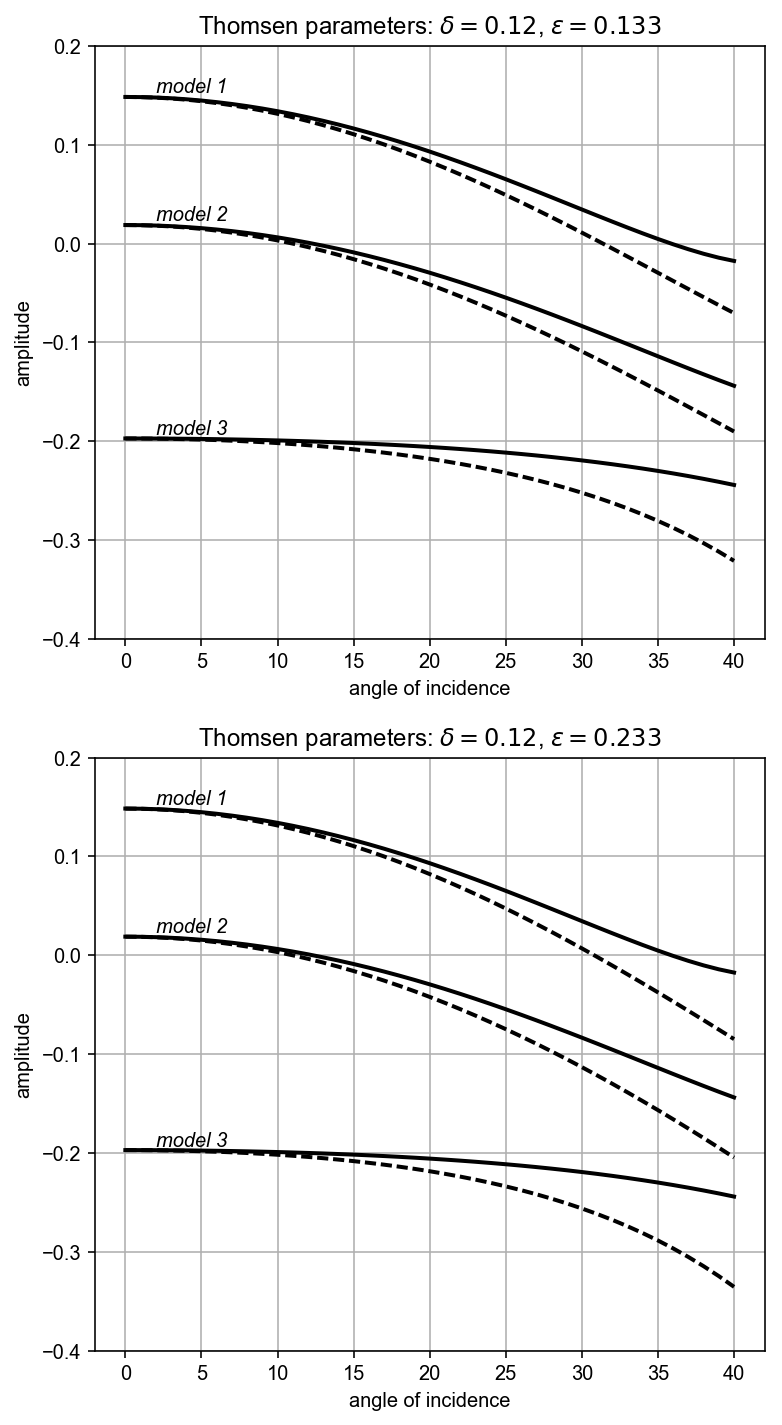

In [7]:
ang=np.arange(0,41,1)

names=['model 1','model 2','model 3']
shale = np.array([[3.3,1.7,2.35],[2.96,1.38,2.43],[2.73,1.24,2.35]])
sand = np.array([[4.2,2.7,2.49],[3.49,2.29,2.14],[2.02,1.23,2.13]])

f,ax=plt.subplots(nrows=2, ncols=1, figsize=(6,12))
plt.figure()
for i in range(3):
    rcz=zoeppritz(shale[i,0],shale[i,1],shale[i,2],sand[i,0],sand[i,1],sand[i,2],ang)
    thoms_d,thoms_e = 0.12, 0.133
    rcr=ruger(shale[i,0],shale[i,1],shale[i,2],thoms_d,thoms_e,sand[i,0],sand[i,1],sand[i,2],0,0,ang)
    
    ax[0].plot(ang, rcr, '--k',lw=2)
    ax[0].set_title(r'Thomsen parameters: $\delta={}$, $\epsilon={}$'.format(thoms_d,thoms_e))
    ax[0].plot(ang, rcz, '-k',lw=2)
    
    thoms_d,thoms_e = 0.12, 0.233
    rcr=ruger(shale[i,0],shale[i,1],shale[i,2],thoms_d,thoms_e,sand[i,0],sand[i,1],sand[i,2],0,0,ang)
    ax[1].plot(ang, rcr, '--k',lw=2)
    ax[1].set_title(r'Thomsen parameters: $\delta={}$, $\epsilon={}$'.format(thoms_d,thoms_e))
    ax[1].plot(ang, rcz, '-k',lw=2)
    for aa in ax:
        aa.grid()
        aa.set_xlabel('angle of incidence'), aa.set_ylabel('amplitude')
        aa.set_ylim(-.4, .2)
        aa.text(2,rcz[0],names[i], style='italic', fontsize=10, ha='left', va='bottom')

## reproducing Ruger's figures from his 1997 Geophysics article

(not sure if it's ok, vertical scale looks funny)

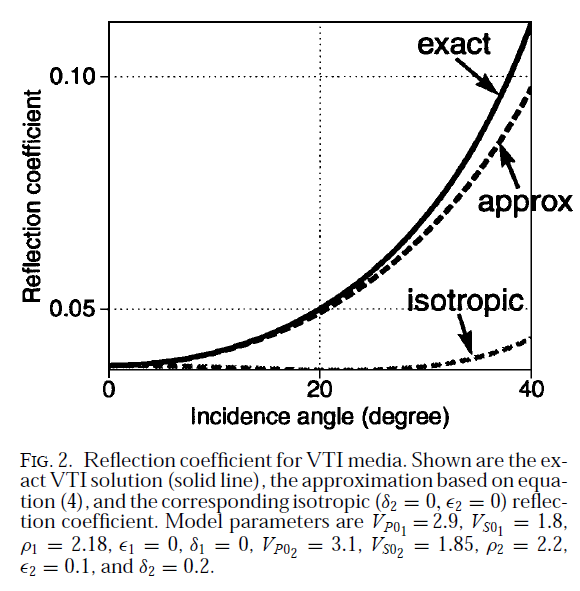

In [8]:
Image(filename='Ruger_1997_fig2.png', width=400)

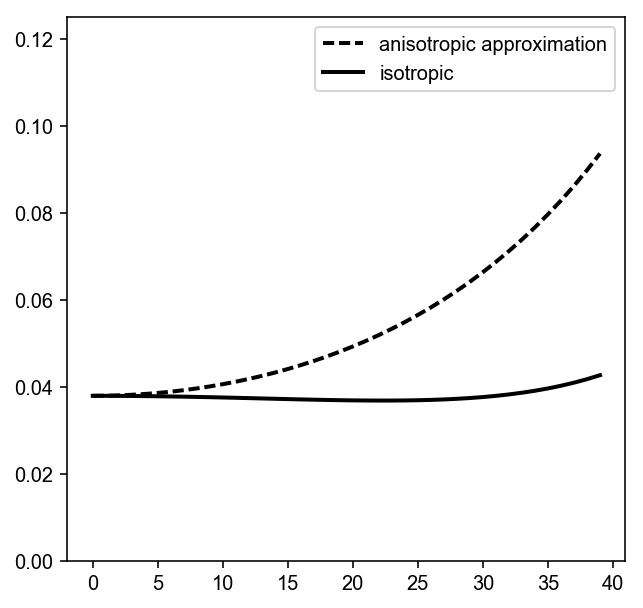

In [9]:
# ruger 1997, fig 2, p715
ang=np.arange(0,40,1)
rc=ruger(2900,1800,2.18,0,0,3100,1850,2.2,0.2,0.1,ang)
rcz=zoeppritz(2900,1800,2.18,3100,1850,2.2,ang)

plt.figure(figsize=(5,5))
plt.plot(ang,rc,'--k', lw=2, label='anisotropic approximation')
plt.plot(ang,rcz,'-k', lw=2, label='isotropic')
plt.ylim(0,0.125)
plt.legend(fontsize='medium')

## reproducing figure from Simm & Bacon's book

Page 86, fig. 5.45:

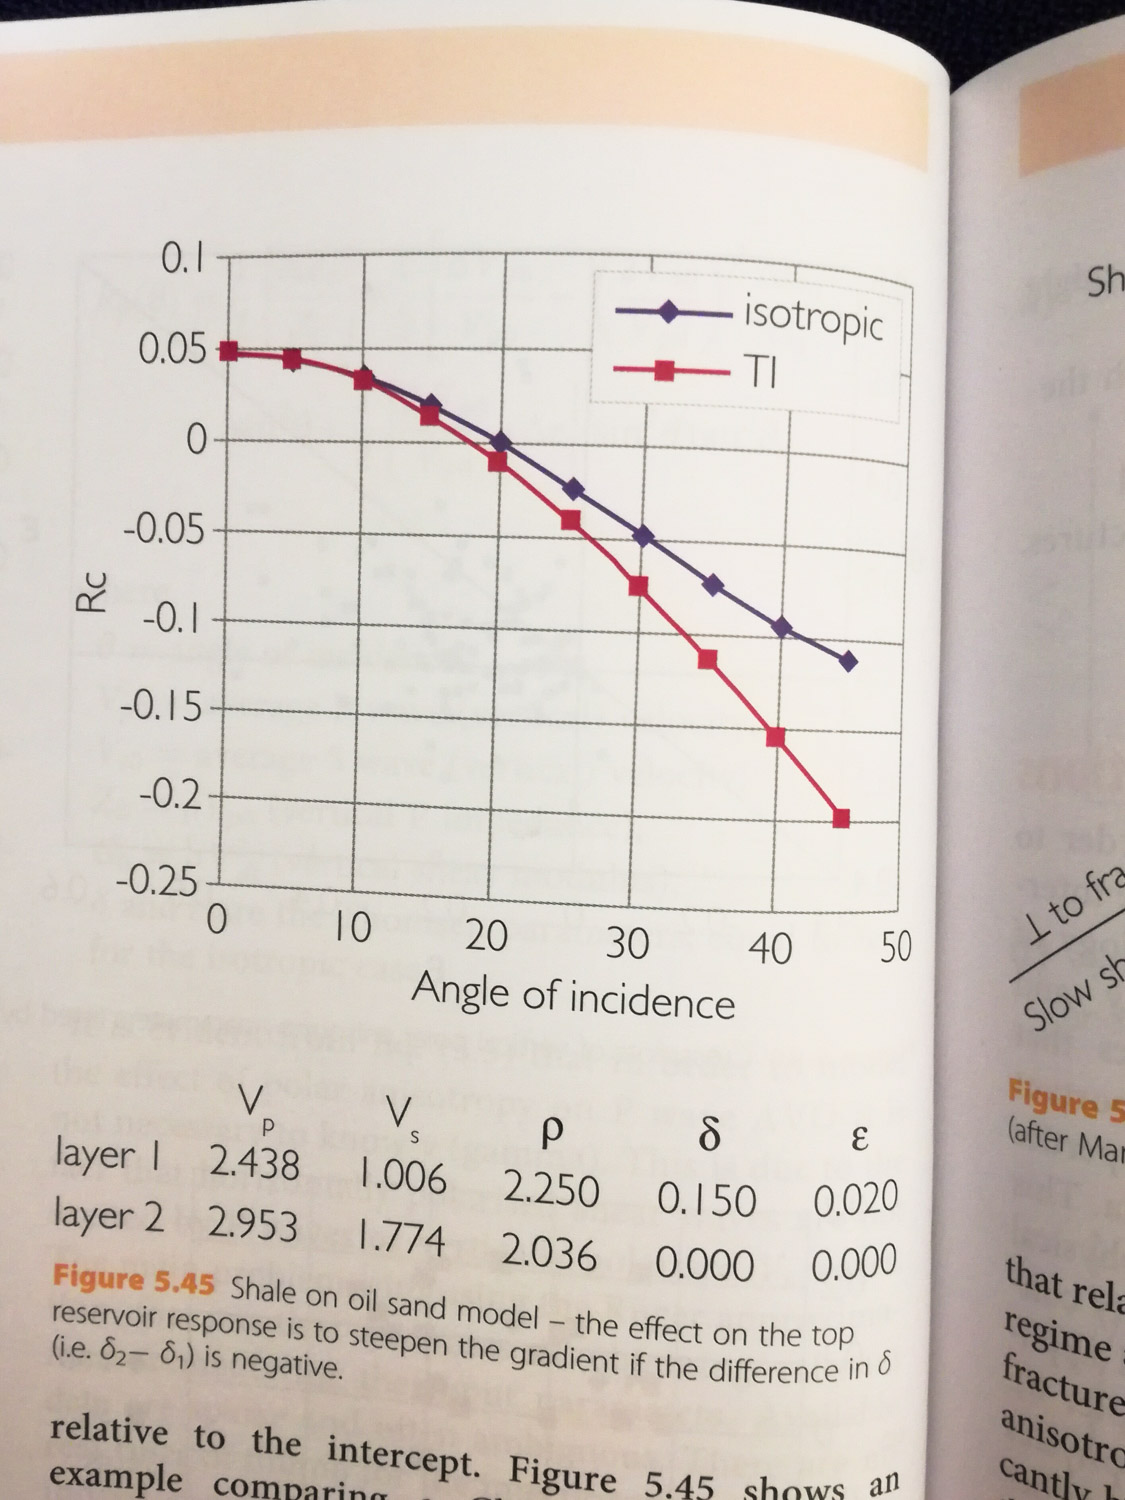

In [16]:
Image(filename='Simm_2014_fig5-45.jpg', retina=True)

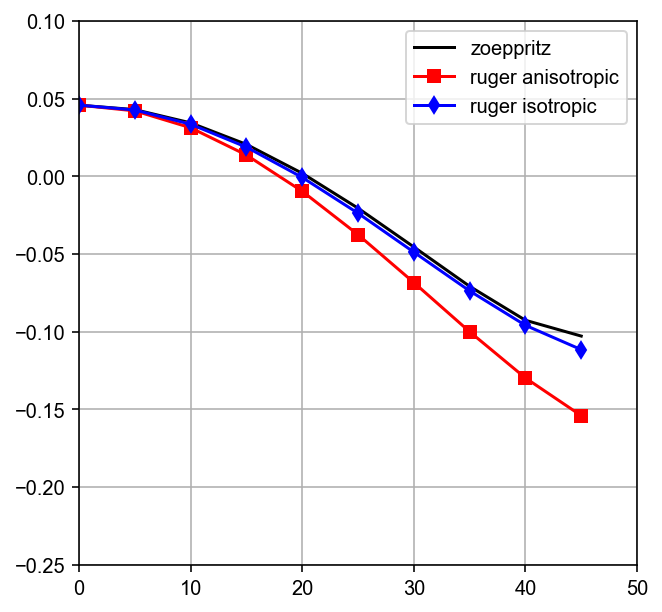

In [17]:
# simm & bacon, seismic amplitude, pag. xxx
ang=np.arange(0,50,5)
rc=zoeppritz(2438,1006,2.25,2953,1774,2.036,ang)
rc0=ruger(2438,1006,2.25,0.15,0.02,2953,1774,2.036,0.,0.,ang)
rc1=ruger(2438,1006,2.25,0.00,0.00,2953,1774,2.036,0.,0.,ang)

plt.figure(figsize=(5,5))
plt.plot(ang,rc,'-k', label='zoeppritz')
plt.plot(ang,rc0,'-sr', label='ruger anisotropic')
plt.plot(ang,rc1,'-db', label='ruger isotropic')
plt.ylim(-0.25,0.1), plt.xlim(0,50)
plt.grid()
plt.legend(fontsize='medium')